In [ ]:
To run the jobs

msub <job.sh>


To view jobs:

qstat -u agb214
showq -u agb214
qstat -r -u agb214
qstat -i -u agb214


To delete jobs:

mjobctl -c <jobname.sh>
qselect -u agb214 | xargs qdel

for i in {888947..888996}; do mjobctl -c $i.mgmt01.cluster.local; done




To follow error logs

sudo tail -f <filename.log>


Options

#PBS -l feature=highmem # High Memory
#PBS -l feature=gpu     # GPU
#PBS -l feature=phi     # Phi


conda install -n anvio5 -c bioconda kaiju

#make sure in ~/tools directory
git clone <web address>
python setup.py install
    
rsync -avzh agb214@login.isca.ex.ac.uk:/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/gene_calls_nr.names /home/minion/Desktop/

module add MCL/14.137-intel-2016b
module avail

BLAST+/2.2.30-foss-2015a-Python-2.7.9

https://astrobiomike.github.io/metagenomics/metagen_anvio

screens
ctrl + a + d --> detach

screen -S test --> make a screen called test
screen -r test --> go to the screen called test
screen -ls
screen -X -S <id> kill
top -u agb214
ctrl+a c get out of top

ls -l | wc -l

module add OpenSSL/1.0.1f-ictce-4.1.13


In [ ]:
#!/bin/bash
#PBS -v # set verbose output
#PBS -N 
#PBS -d .
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -l vmem=128gb
#PBS -j oe
#PBS -M agb214@exeter.ac.uk
#PBS -m ae
#PBS -l feature=phi     # Phi

In [ ]:
# list of all cellular fractions metagenomes

2654_12_AE1712_C16_N8_14_200m
2654_11_AE1712_C16_N1_7_80m
2654_10_AE1712_C14_N4_19_200m
2654_9_AE1712_C14_N3_8_80m
2654_8_AE1712_C11_N8_14_200m
2654_7_AE1712_C11_N1_7_80m
2654_6_AE1712_C8_N19_24_200m
2654_5_AE1712_C8_N7_12_80m
2654_4_AE1712_C6_N8_17_200m
2654_3__AE1712_C6_N1_7_80m
2654_2_AE1712_C3_N8_14_200m 
2654_1_AE1712_C3_N1_7_80m

In [ ]:
# python script to take only the cellular portion contigs

from Bio import SeqIO

cellular_contigs_only = []

for record in SeqIO.parse('contigs.from.anvio.fa', 'fasta'):
    if record.id.startswith('BS'):
        continue
    cellular_contigs_only.append(record)
    
SeqIO.write(cellular_contigs_only, 'cellular.contigs.from.anvio.fa', 'fasta')


In [ ]:
#this runs the samples against bowtie2 removing something above or below 95%

bowtie2-build --seed 1111 cellular.contigs.from.anvio.fa cellular.contigs.from.anvio

#!/bin/bash
#PBS -V # set verbose output
#PBS -N test.run.mapping
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts/runs
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job.
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l procs=16 # either this to specify number of processors.
#PBS -j oe

source activate anvio5

PROJECT_HOME=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data
OUT_DIR=$PROJECT_HOME/mappings

SAMPLE_NAME=2654_10_AE1712_C14_N4_19_200m 

MAPPING_LOGFILE=$OUT_DIR/$SAMPLE_NAME.log
mkdir -p $OUT_DIR

cd "/local/pbstmp.${PBS_JOBID}"

bowtie2 --threads 16 -x $PROJECT_HOME/cellular.contigs.from.anvio \
                -1 $PROJECT_HOME/$SAMPLE_NAME.fwd.fq.gz \
                -2 $PROJECT_HOME/$SAMPLE_NAME.rev.fq.gz \
                --no-unal \
                -S $SAMPLE_NAME.sam 2>&1 | tee -a $MAPPING_LOGFILE

samtools view -F 4 -bS $SAMPLE_NAME.sam > $SAMPLE_NAME.raw.bam
samtools sort $SAMPLE_NAME.raw.bam -o $SAMPLE_NAME.vs.ae1712.cellular.sorted.bam
samtools index $SAMPLE_NAME.vs.ae1712.cellular.sorted.bam

#mv $SAMPLE_NAME.vs.ae1712.cellular.sorted.bam*

source activate bamm

bamm filter -b $SAMPLE_NAME.vs.ae1712.cellular.sorted.bam --percentage_id 0.95 2>&1 | tee -a $MAPPING_LOGFILE
samtools sort -@ 16 \
-o $SAMPLE_NAME.vs.ae1712.cellular.sorted.95pc.bam \
$SAMPLE_NAME.vs.ae1712.cellular.sorted_filtered.bam

samtools index $SAMPLE_NAME.vs.ae1712.cellular.sorted.95pc.bam
mv $SAMPLE_NAME.vs.ae1712.cellular.sorted.95pc.bam* $OUT_DIR

In [ ]:
#this generates the contigs database required to run all of anvio off

source activate anvio5

anvi-gen-contigs-database -f cellular.contigs.from.anvio.fa -o contigs.db -n 'AE1712'


In [1]:
#this job was sumbitted to run hmms, pfams and ncbi cogs on the contigs database.
#dont forget to set up the pfams and cogs before running this, script below 

anvi-setup-ncbi-cogs  
anvi-setup-pfams

#note: Commented out line 96 in `/gpfs/ts0/home/agb214/anaconda3/envs/anvio5/lib/python3.6/site-packages/anvio/pfam.py` disabling check error 

#!/bin/bash
#PBS -V # set verbose output
#PBS -N anvio.hmms.pfams.ncbi_cogs
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts/runs
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -j oe


PROFILE_LOG=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data.log

source activate anvio5
cd /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data
anvi-run-hmms -c contigs.db --num-threads 16 2>&1 | tee -a $PROFILE_LOG 
anvi-run-pfams -c contigs.db --num-threads 16 2>&1 | tee -a $PROFILE_LOG
anvi-run-ncbi-cogs -c contigs.db --num-threads 16 2>&1 | tee -a $PROFILE_LOG

SyntaxError: invalid syntax (<ipython-input-1-a90224bc551c>, line 4)

In [ ]:
#this downloads the kaiju database selected for the NCBI non-redudant database (nr)
#https://github.com/bioinformatics-centre/kaiju
#http://merenlab.org/2016/06/18/importing-taxonomy/#kaiju

#!/bin/bash
#PBS -v # set verbose output
#PBS -N Download.RefSeq.database.for.Kaiju
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts/runs
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -j oe
#PBS -l feature=gpu     # GPU

mkdir /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/ref/kaijudb
cd /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/ref/kaijudb
../kaiju/bin/./makeDB.sh -n -t 16

In [ ]:
#this job runs kaiju on the contigs database previously set up after downloading a kaiju database

#!/bin/bash
#PBS -V # set verbose output
#PBS -N anvi.run.kaiju
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts/runs
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=32
#PBS -j oe
#PBS -l feature=highmem # High Memory

DATA=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data
PROFILE_LOG=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts/runs/kaiju.log
KAIJUDB=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/ref/kaijudb

source activate anvio5
cd $DATA
kaiju -t $KAIJUDB/nodes.dmp \
      -f $KAIJUDB/kaiju_db_nr.fmi \
      -i $DATA/gene_calls.fa \
      -o $DATA/gene_calls_nr.out \
      -z 32 \
      -v 2>&1 | tee -a $PROFILE_LOG

addTaxonNames -t $KAIJUDB/nodes.dmp \
              -n $KAIJUDB/names.dmp \
              -i $DATA/gene_calls_nr.out \
              -o $DATA/gene_calls_nr.names \
              -r superkingdom,phylum,class,order,family,genus,species

cp contigs.db contigs.db.bak.pre.kaiju

#anvi-import-taxonomy-for-genes -i $DATA/gene_calls_nr.names \
#                               -c $DATA/contigs.db \
#                               -p kaiju \
#                               --just-do-it 2>&1 | tee -a $PROFILE_LOG

In [ ]:
#!/bin/bash
#PBS -V # set verbose output
#PBS -N 1_AE1712_C3_N1_7_80m
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts/runs
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=32
#PBS -j oe
#PBS -l feature=highmem # High Memory

source activate anvio5

PROJECT_HOME=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data

SAMPLE_NAME=1_AE1712_C3_N1_7_80m
mkdir $PROJECT_HOME/assemblies/$SAMPLE_NAME
OUT_DIR=$PROJECT_HOME/assemblies/$SAMPLE_NAME

cd $PROJECT_HOME

LOGFILE=$OUT_DIR.log
BAMFILE=$PROJECT_HOME/mappings/2654.1.AE1712.C3.N1.7.80m.vs.ae1712.cellular.sorted.95pc.bam

anvi-profile \
--input-file $BAMFILE \
--contigs-db contigs.db \
--output-dir $OUT_DIR \
--sample-name $SAMPLE_NAME \
--overwrite-output-destinations \
--profile-SCVs \
--num-threads 32 2>&1 | tee -a $LOGFILE

In [ ]:
#Merging profiles for anvio
#hierachical clustering forced due to 35K splits >25K recomended top limit

#!/bin/bash
#PBS -V # set verbose output
#PBS -N hi.clust.anvi-merge
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts
#PBS -q pq
#PBS -l walltime=168:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -j oe

source activate anvio5

PROJECT_HOME=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/
DATABASE=$PROJECT_HOME/assemblies
LOGFILE=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts/Hi.Clus.merge.log

anvi-merge \
$DATABASE/AE1712_C11_N1_7_80m/PROFILE.db \
$DATABASE/AE1712_C11_N8_14_200m/PROFILE.db \
$DATABASE/AE1712_C14_N3_8_80m/PROFILE.db \
$DATABASE/AE1712_C14_N4_19_200m/PROFILE.db \
$DATABASE/AE1712_C3_N1_7_80m/PROFILE.db \
$DATABASE/AE1712_C6_N8_17_200m/PROFILE.db \
$DATABASE/AE1712_C16_N1_7_80m/PROFILE.db \
$DATABASE/AE1712_C3_N8_14_200m/PROFILE.db \
$DATABASE/AE1712_C8_N19_24_200m/PROFILE.db \
$DATABASE/AE1712_C16_N8_14_200m/PROFILE.db \
$DATABASE/AE1712_C6_N1_7_80m/PROFILE.db \
$DATABASE/AE1712_C8_N7_12_80m/PROFILE.db \
--contigs-db $PROJECT_HOME/contigs.db \
--output-dir $PROJECT_HOME/SAMPLES_MERGED_2 \
--sample-name merged_profiles_2 \
--enforce-hierarchical-clustering \
--overwrite-output-destinations | tee -a $LOGFILE

In [ ]:
#Getting a metabat clustering thing

cd /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/profiles
#to get a depth file
jgi_summarize_bam_contig_depths --outputDepth depth.txt *.bam


#!/bin/bash
#PBS -V # set verbose output
#PBS -N metabat
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts/runs
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -j oe
#PBS -l feature=phi # Phi

source activate anvio5

LOGFILE=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/scripts/runs/metabat2.log

cd /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/
metabat \
-i cellular.contigs.from.anvio.fa \
-a depth.txt \
-o metabat2 \
--maxP 90 \
--maxEdges 500 \
--minS 75 \
--noAdd \
--numThreads 16 | tee -a $LOGFILE


#making bamm coverage file for maxbin

#!/bin/bash
#PBS -V # set verbose output
#PBS -N tpmean.bamm
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts/runs
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -j oe
#PBS -l feature=phi # Phi

source activate bamm
cd /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/mappings
LOGFILE=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts/runs/tpmean.bamm.log

bamm parse -c coverage.tsv -m tpmean -b *.bam | tee -a $LOGFILE

#tpmean data split into different depth files with awk

awk '{print $1"\t"$X}' coverage.tsv > <bam_file> 

#making maxbin bin contigs using above script

#!/bin/bash
#PBS -V # set verbose output
#PBS -N maxbin
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts/runs
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -j oe
#PBS -l feature=phi # Phi

source activate anvio5

cd /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/maxbin
MAXBIN=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/maxbin
LOGFILE=$MAXBIN/maxbin.log

run_MaxBin.pl \
-thread 16 \
-contig ../cellular.contigs.from.anvio.fa \
-out maxbin \
-abund $MAXBIN/AE1712.C3.N1.7.80m.txt \
-abund2 $MAXBIN/AE1712.C3.N8.14.200m.txt \
-abund3 $MAXBIN/AE1712.C6.N1.7_80m.txt \
-abund4 $MAXBIN/AE1712.C11.N1.7.80m.txt \
-abund5 $MAXBIN/AE1712.C6.N8.17.200m.txt \
-abund6 $MAXBIN/AE1712.C11.N8.14.200m.txt \
-abund7 $MAXBIN/AE1712.C8.N19.24.200m.txt \
-abund8 $MAXBIN/AE1712.C14.N3.8.80m.txt \
-abund9 $MAXBIN/AE1712.C8.N7.12.80m.txt \
-abund10 $MAXBIN/AE1712.C14.N4.19.200m.txt \
-abund11 $MAXBIN/AE1712.C16.N1.7.80m.txt \
-abund12 $MAXBIN/AE1712.C16.N8.14.200m.txt | tee -a $LOGFILE


#groopm

source activate bamm

mkdir ~/Desktop/groopm
GROOPM=~/Desktop/groopm
MAPPINGS=~/Desktop/mappings
LOGFILE=$GROOPM/groopm.parse.log
LOGFILE2=$GROOPM/groopm.core.log
LOGFILE3=$GROOPM/groopm.recruit.log
LOGFILE4=$GROOPM/groopm.extract.log

cd $GROOPM

groopm parse \
database.gm \
cellular.contigs.from.anvio.fa \
$MAPPINGS/2654.1.AE1712.C3.N1.7.80m.vs.ae1712.cellular.sorted.95pc.bam \
$MAPPINGS/2654.10.AE1712.C14.N4.19.200m.vs.ae1712.cellular.sorted.95pc.bam \
$MAPPINGS/2654.11.AE1712.C16.N1.7.80m.vs.ae1712.cellular.sorted.95pc.bam \
$MAPPINGS/2654.12.AE1712.C16.N8.14.200m.vs.ae1712.cellular.sorted.95pc.bam \
$MAPPINGS/2654.2.AE1712.C3.N8.14.200m.vs.ae1712.cellular.sorted.95pc.bam \
$MAPPINGS/2654.3.AE1712.C6.N1.7_80m.vs.ae1712.cellular.sorted.95pc.bam \
$MAPPINGS/2654.4.AE1712.C6.N8.17.200m.vs.ae1712.cellular.sorted.95pc.bam \
$MAPPINGS/2654.5.AE1712.C8.N7.12.80m.vs.ae1712.cellular.sorted.95pc.bam \
$MAPPINGS/2654.6.AE1712.C8.N19.24.200m.vs.ae1712.cellular.sorted.95pc.bam \
$MAPPINGS/2654.7.AE1712.C11.N1.7.80m.vs.ae1712.cellular.sorted.95pc.bam \
$MAPPINGS/2654.8.AE1712.C11.N8.14.200m.vs.ae1712.cellular.sorted.95pc.bam \
$MAPPINGS/2654.9.AE1712.C14.N3.8.80m.vs.ae1712.cellular.sorted.95pc.bam | tee -a $LOGFILE

groopm core database.gm -c 1000 -s 10 -b 1000000 | tee -a $LOGFILE2

groopm recruit groopm.db -c 500 -s 200 | tee -a $LOGFILE3

groopm extract groopm.db contigs.fa | tee -a $LOGFILE3


#binsanity
#this process just creates an ID file containing all the names of all the contigs, used later

cd /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/binsanity

Binsanity-profile \
-i ../cellular.contigs.from.anvio.fa \
-s ../mappings/ \
--ids igm_contig_ids.txt \
-c igm_coverage \
-T 16

#the actual clustering process as a job

#!/bin/bash
#PBS -V # set verbose output
#PBS -N binsanity
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts/runs
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -j oe
#PBS -l feature=phi # Phi

source activate binsanity

LOGFILE=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/scripts/runs/binsanity.log

cd /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/binsanity

Binsanity-wf \
-f . \
-p 30 \
-l ../cellular.contigs.from.anvio.fa \
-c igm_coverage.cov.x100.lognorm \
-o IGM-BinsanityWF_30 \
--threads 16 | tee -a $LOGFILE

In [ ]:
#must be run in iPython in /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data directory

#!/usr/bin/env python
from Bio import SeqIO
import glob
import os
import pandas as pd

results = []

#maxbin

file_list = glob.glob('./maxbin/*.fasta')
for f in file_list:
    bin_name = os.path.basename(f).split('.fasta')[0]
    for record in SeqIO.parse(f, 'fasta'):
        results.append((record.id, 'maxbin', bin_name))
        
#metabat

file_list = glob.glob('./metabat_bins/*.fa')
for f in file_list:
    bin_name = os.path.basename(f).split('.fa')[0]
    for record in SeqIO.parse(f, 'fasta'):
        results.append((record.id, 'metabat', bin_name))
        
#binsanity
file_list = glob.glob('./binsanity/IGM-BinsanityWF/*.fna')
for f in file_list:
    bin_name = os.path.basename(f).split('.fna')[0]
    bin_name = bin_name.replace('cellular.contigs.from.anvio_', '')
    for record in SeqIO.parse(f, 'fasta'):
        results.append((record.id, 'binsanity', bin_name))
        

df = pd.DataFrame(results, columns=['contig', 'bin_type', 'bin'])
df = df.pivot(index='contig', columns='bin_type', values='bin')

df.to_csv('contig.bins.tsv', sep='\t', index=True)

In [ ]:
from Bio import SeqIO #from biopython import the following packages SeqIO - helps read and write sequence data
import glob #helps with pathing on linux machines
import os #read and write files
import pandas as pd #additional data management options 



def process_file(results_list, output_name): #make a function called process_file with inputs to be results_list and output_name
    df = pd.DataFrame(results_list, columns=['contig', 'bin']) #object df is a dataframe with input results_list and contains columns defined as contigs and bins
    df.to_csv(output_name, sep='\t', index=False) #function to turn the df into a csv file seperated by tab without an indexing data

results = [] #make the results object 

#maxbin
file_list = glob.glob('./maxbin/*.fasta') #file_list defined as anything in maxbin filepath with fasta in it using glob package for pathing
for f in file_list: #for every item in the file list do
    bin_name = os.path.basename(f).split('.fasta')[0] #make the bin_name the filename minus the word fasta
    for record in SeqIO.parse(f, 'fasta'): #using SeqIO package look for the item name then do
        results.append((record.id, bin_name))#add the results of the parse and only take the record.id (contig name) and the bin_name from above

process_file(results, 'maxbin.bins.tsv') #make the file from all the results from the results.append function into <filename>
#metabat

results = [] #clear the results object 
file_list = glob.glob('./metabat2/*.fa')
for f in file_list:
    bin_name = os.path.basename(f).split('.fa')[0]
    for record in SeqIO.parse(f, 'fasta'):
        results.append((record.id, bin_name))


process_file(results, 'metabat.bins.tsv')        

#binsanity
results = []
file_list = glob.glob('./binsanity/IGM-BinsanityWF/*.fna')
for f in file_list:
    bin_name = os.path.basename(f).split('.fna')[0]
    bin_name = bin_name.replace('cellular.contigs.from.anvio_', '')
    for record in SeqIO.parse(f, 'fasta'):
        results.append((record.id, bin_name))

process_file(results, 'binsanity.bins.tsv')

In [ ]:
CheckM boundries

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4484387/bin/1043tb03.jpg

In [ ]:
anvi-import-collection \
metabat2.bins.tsv \
-p SAMPLES-MERGED/PROFILE.db \
-c contigs.db \
-C MetaBat2 \
--contigs-mode

anvi-export-collection \
-p SAMPLES-MERGED/PROFILE.db \
-C MetaBat2 \
-O MetaBat2

anvi-import-misc-data \
MetaBat2.txt \
-p SAMPLES-MERGED/PROFILE.db \
-t items

In [ ]:
CAT/BAT: tool for taxonomic classification of contigs and metagenome-assembled genomes (MAGs)
https://github.com/dutilh/CAT
    
PATH=$PATH:/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/tools/CAT/CAT/CAT_pack/
PATH=$PATH:/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/tools/CAT/CAT/old_CAT

    
#!/bin/bash
#PBS -V # set verbose output
#PBS -N CAT.prepare.fresh
#PBS -d /gpfs/ts0/home/agb214/tools/CAT
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -j oe
#PBS -l feature=phi # Phi

LOGFILE=/gpfs/ts0/home/agb214/tools/CAT/CAT_prepare_fresh.log
source activate CAT
cd /gpfs/ts0/home/agb214/tools/CAT
CAT_pack/CAT prepare --fresh | tee -a $LOGFILE

#!/bin/bash
#PBS -V # set verbose output
#PBS -N CAT.prepare.existing
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/CAT
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=32
#PBS -j oe
#PBS -l feature=highmem # High Memory

LOGFILE=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/CAT/CAT_prepare_existing.log
source activate CAT
cd /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/CAT
CAT_pack/CAT prepare --existing -d 2018-10-16_CAT_database -t 2018-10-16_taxonomy

#!/bin/bash
#PBS -V # set verbose output
#PBS -N CAT.binsanity
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/CAT
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=32
#PBS -j oe
#PBS -l feature=highmem # High Memory

source activate CAT

/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/CAT/CAT_pack/CAT bins \
-b /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/maxbin \
-d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/CAT/2018-10-16_CAT_database/ \
-t /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/data/CAT/2018-10-16_taxonomy/ \
--bin_suffix .fasta

/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/tools/CAT/CAT/CAT_pack/CAT contigs \
-c AE1712-80m-contigs-2k5.fa \
-d ../../tools/CAT/2018-10-16_CAT_database/ \
-t ../../tools/CAT/2018-10-16_taxonomy/ \
-n 16



CAT add_names \
-i out.BAT.ORF2LCA.txt \
-o out.BAT.ORF2LCA.names.txt \
-t ../2018-10-16_taxonomy


In [ ]:
https://www.nature.com/articles/s41564-018-0171-1
Fig. 1: Overview of the DAS Tool algorithm.
    
#!/bin/bash
#PBS -V # set verbose output
#PBS -N DASTool
#PBS -d /gpfs/ts0/home/agb214/tools/DAS_Tool-master
#PBS -q pq
#PBS -l walltime=48:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -j oe
#PBS -l feature=phi # Phi

source activate DAS
cd /gpfs/ts0/home/agb214/tools/DAS_Tool-master

./DAS_Tool \
-i metabat2.bins.tsv,metabat.bins.tsv,maxn.bins.tsv,binsanity.bins.tsv \
-l metabat2,metabat,maxbin,binsanity \
-c cellular.contigs.from.anvio.fa \
-o DASToolRun1 \
--threads 16

In [ ]:
#installing centrifuge https://ccb.jhu.edu/software/centrifuge/manual.shtml
http://merenlab.org/2016/06/18/installing-third-party-software/#centrifuge
http://merenlab.org/2016/06/18/importing-taxonomy/#centrifuge

    #installing centrifuge itself
cd ~/tools
mkdir CENTRIFUGE
cd ~/tools/CENTRIFUGE
export CENTRIFUGE_BASE="~/tools/CENTRIFUGE"
cd $CENTRIFUGE_BASE
git clone https://github.com/infphilo/centrifuge.git
cd centrifuge
make
export PATH=$PATH:$CENTRIFUGE_BASE/centrifuge
centrifuge --version | head -n 1 #should return "centrifuge-class version v1.X.X"

    
## OR USE make 
https://github.com/khyox/recentrifuge/wiki/Centrifuge-nt    
    
cd your_centrifuge_folder/indices
make THREADS=8 nt
#with Dustmaster installed 
ftp://ftp.ncbi.nlm.nih.gov/pub/agarwala/dustmasker/
wget ftp://ftp.ncbi.nlm.nih.gov/pub/agarwala/dustmasker/dustmasker

#manual way
mkdir nt
cd nt
wget ftp://ftp.ncbi.nih.gov/blast/db/FASTA/nt.gz
gunzip nt.gz
mv -v nt nt.fa

mkdir taxonomy
cd taxonomy
wget ftp://ftp.ncbi.nlm.nih.gov/pub/taxonomy/taxdump.tar.gz
tar xvzf taxdump.tar.gz
cd ..

wget "ftp://ftp.ncbi.nih.gov/pub/taxonomy/accession2taxid/nucl_*.accession2taxid.gz"
wget ftp://ftp.ncbi.nih.gov/pub/taxonomy/accession2taxid/pdb.accession2taxid.gz
gunzip -c *.accession2taxid.gz | awk -v OFS='\t' '{print $2, $3}' >> acc2tax.map

mv nt.fa nt_unmasked.fa 
dustmasker -infmt fasta -in nt_unmasked.fa -level 20 -outfmt fasta | sed '/^>/! s/[^AGCT]/N/g' > nt.fa

centrifuge-build --ftabchars=14 -p 32 --bmax 1342177280 --conversion-table acc2tax.map --taxonomy-tree taxonomy/nodes.dmp --name-table taxonomy/names.dmp nt.fa nt


#other way one way 

Use centrifuge-download to download genomes from NCBI.
centrifuge-download -o taxonomy taxonomy
centrifuge-download -o library -m -d "archaea,bacteria,viral" refseq > seqid2taxid.map

To build the index, first concatenate all downloaded sequences into a single file, and then run 

cat library/*/*.fna > input-sequences.fna

## build centrifuge index with 4 threads
centrifuge-build -p 4 --conversion-table seqid2taxid.map \
                 --taxonomy-tree taxonomy/nodes.dmp --name-table taxonomy/names.dmp \
                 input-sequences.fna abv

After the index building, all but the *.[123].cf index files may be removed. 
I.e. the files in the library/ and taxonomy/ directories are no longer needed.

#NCBI BLAST's nt database contains all spliced non-redundant coding sequences from multiplpe databases, inferred from genommic sequences.
#Building an index with any database requires the user to creates a sequence ID to taxonomy ID map that can be generated from a GI taxid dump:
    wget ftp://ftp.ncbi.nih.gov/blast/db/FASTA/nt.gz
gunzip nt.gz && mv -v nt nt.fa

# Get taxonomy file
wget ftp://ftp.ncbi.nih.gov/pub/taxonomy/gi_taxid_nucl.dmp.gz
gunzip -c gi_taxid_nucl.dmp.gz | sed 's/^/gi|/' > gi_taxid_nucl.map

# build index using 16 cores and a small bucket size, which will require less memory
centrifuge-build \
-p 16 \
--bmax 1342177280 \
--conversion-table gi_taxid_nucl.map \
--taxonomy-tree taxonomy/nodes.dmp \
--name-table taxonomy/names.dmp \ 
nt.fa nt | tee -a centrifuge.build.log


In [ ]:
for i in $(cat ALOHA.BATS.ASSEMBLIES.txt); do echo "downloading $i"; wget $i; done

In [ ]:
#Make two anvio profiles, one for 200m cellular fraction and 80m

#cat all the 200m and 80m contigs together
cat * > AE1712-200m-contigs-2k5.fa
cat * > AE1712-80m-contigs-2k5.fa

#reformat the fasta to ensure no horrible deflines, to 2500bps min 
anvi-script-reformat-fasta \
AE1712-200m-contigs-2k5.fa \
-o AE1712-200m-contigs-2k5-fixed.fa \
-l 2500 \
--simplify-names
mv AE1712-200m-contigs-2k5-fixed.fa AE1712-200m-contigs-2k5.fa

anvi-script-reformat-fasta \
AE1712-80m-contigs-2k5.fa \
-o AE1712-80m-contigs-2k5-fixed.fa \
-l 2500 \
--simplify-names
mv AE1712-80m-contigs-2k5-fixed.fa AE1712-80m-contigs-2k5.fa

#build the bowtie2 index
bowtie2-build AE1712-200m-contigs-2k5.fa 200m-contigs
bowtie2-build AE1712-80m-contigs-2k5.fa 80m-contigs

#make a directory for the mappings
mkdir /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/200m/mappings
mkdir /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/80m/mappings

#!/bin/bash
#PBS -V # set verbose output
#PBS -N 200m-bowtie-bamm
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/200m
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l procs=16 # either this to specify number of processors.
#PBS -j oe
#PBS -l feature=phi # Phi

PROJECT_HOME=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/200m
OUT_DIR=$PROJECT_HOME/mappings
READS=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/200m/reads

SAMPLE_NAME=200m-contigs

MAPPING_LOGFILE=$OUT_DIR/$SAMPLE_NAME.log

cd $PROJECT_HOME

for i in $(cat read-names.txt); 
do source activate anvio5; 
bowtie2 --threads 16 -x $SAMPLE_NAME -1 $READS/$i.fwd* -2 $READS/$i.rev* --no-unal -S $SAMPLE_NAME.$i.sam 2>&1 | tee -a $MAPPING_LOGFILE;

samtools view -F 4 -bS $SAMPLE_NAME.$i.sam > $SAMPLE_NAME.vs.$i.raw.bam;
samtools sort $SAMPLE_NAME.vs.$i.raw.bam -o $SAMPLE_NAME.vs.$i.sorted.bam;
samtools index $SAMPLE_NAME.vs.$i.sorted.bam;

source activate bamm;

bamm filter -b $SAMPLE_NAME.vs.$i.sorted.bam --percentage_id 0.95 2>&1 | tee -a $MAPPING_LOGFILE;
samtools sort -@ 32 \
-o $SAMPLE_NAME.vs.$i.sorted.95pc.bam \
$SAMPLE_NAME.vs.$i.sorted_filtered.bam;

samtools index $SAMPLE_NAME.vs.$i.sorted.95pc.bam;
mv $SAMPLE_NAME.vs.$i.sorted.95pc.bam* $OUT_DIR;

rm *vs.$i*;
rm *$i.sam;
done

#!/bin/bash
#PBS -V # set verbose output
#PBS -N 80m-bowtie-bamm
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/80m
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l procs=16 # either this to specify number of processors.
#PBS -j oe
#PBS -l feature=phi # Phi

PROJECT_HOME=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/80m
OUT_DIR=$PROJECT_HOME/mappings
READS=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/80m/reads

SAMPLE_NAME=80m-contigs

MAPPING_LOGFILE=$OUT_DIR/$SAMPLE_NAME.log

cd $PROJECT_HOME

for i in $(cat read-names.txt); 
do source activate anvio5; 
bowtie2 --threads 16 -x $SAMPLE_NAME -1 $READS/$i.fwd* -2 $READS/$i.rev* --no-unal -S $SAMPLE_NAME.$i.sam 2>&1 | tee -a $MAPPING_LOGFILE;

samtools view -F 4 -bS $SAMPLE_NAME.$i.sam > $SAMPLE_NAME.vs.$i.raw.bam;
samtools sort $SAMPLE_NAME.vs.$i.raw.bam -o $SAMPLE_NAME.vs.$i.sorted.bam;
samtools index $SAMPLE_NAME.vs.$i.sorted.bam;

source activate bamm;

bamm filter -b $SAMPLE_NAME.vs.$i.sorted.bam --percentage_id 0.95 2>&1 | tee -a $MAPPING_LOGFILE;
samtools sort -@ 32 \
-o $SAMPLE_NAME.vs.$i.sorted.95pc.bam \
$SAMPLE_NAME.vs.$i.sorted_filtered.bam;

samtools index $SAMPLE_NAME.vs.$i.sorted.95pc.bam;
mv $SAMPLE_NAME.vs.$i.sorted.95pc.bam* $OUT_DIR;

rm *vs.$i*;
rm *$i.sam;
done

#generate a contigs database 
anvi-gen-contigs-database \
-f AE1712-200m-contigs-2k5.fa \
-o contigs.db \
-n 'contigs database for AE1712 cellular fraction 200m only'

anvi-gen-contigs-database \
-f AE1712-80m-contigs-2k5.fa \
-o contigs.db \
-n 'contig database for AE1712 cellular fraction 80m only'

#generate HMMs
anvi-run-hmms -c contigs.db

#look for ncbi cogs - only works with screens
anvi-setup-ncbi-cogs --reset --just-do-it -T 16
anvi-run-ncbi-cogs -c contigs.db -T 16 --sensitive
anvi-setup-pfams --reset
anvi-run-pfams -c contigs.db -T 16 #doesn't work

#rename the bamfiles not to start with numbers (because anvi'o)
mv 200m-contigs.vs.2654_10_AE1712_C14_N4_19_200m.sorted.95pc.bam AE1712_C14_N4_19_200m.bam
mv 200m-contigs.vs.2654_10_AE1712_C14_N4_19_200m.sorted.95pc.bam.bai AE1712_C14_N4_19_200m.bam.bai
mv 200m-contigs.vs.2654_12_AE1712_C16_N8_14_200m.sorted.95pc.bam AE1712_C16_N8_14_200m.bam
mv 200m-contigs.vs.2654_12_AE1712_C16_N8_14_200m.sorted.95pc.bam.bai AE1712_C16_N8_14_200m.bam.bai
mv 200m-contigs.vs.2654_2_AE1712_C3_N8_14_200m.sorted.95pc.bam AE1712_C3_N8_14_200m.bam
mv 200m-contigs.vs.2654_2_AE1712_C3_N8_14_200m.sorted.95pc.bam.bai AE1712_C3_N8_14_200m.bam.bai
mv 200m-contigs.vs.2654_4_AE1712_C6_N8_17_200m.sorted.95pc.bam AE1712_C6_N8_17_200m.bam
mv 200m-contigs.vs.2654_4_AE1712_C6_N8_17_200m.sorted.95pc.bam.bai AE1712_C6_N8_17_200m.bam.bai
mv 200m-contigs.vs.2654_6_AE1712_C8_N19_24_200m.sorted.95pc.bam AE1712_C8_N19_24_200m.bam
mv 200m-contigs.vs.2654_6_AE1712_C8_N19_24_200m.sorted.95pc.bam.bai AE1712_C8_N19_24_200m.bam.bai
mv 200m-contigs.vs.2654_8_AE1712_C11_N8_14_200m.sorted.95pc.bam AE1712_C11_N8_14_200m.bam
mv 200m-contigs.vs.2654_8_AE1712_C11_N8_14_200m.sorted.95pc.bam.bai AE1712_C11_N8_14_200m.bam.bai

mv 80m-contigs.vs.2654_11_AE1712_C16_N1_7_80m.sorted.95pc.bam AE1712_C16_N1_7_80m.bam
mv 80m-contigs.vs.2654_11_AE1712_C16_N1_7_80m.sorted.95pc.bam.bai AE1712_C16_N1_7_80m.bam.bai
mv 80m-contigs.vs.2654_1_AE1712_C3_N1_7_80m.sorted.95pc.bam AE1712_C3_N1_7_80m.bam
mv 80m-contigs.vs.2654_1_AE1712_C3_N1_7_80m.sorted.95pc.bam.bai AE1712_C3_N1_7_80m.bam.bai
mv 80m-contigs.vs.2654_3__AE1712_C6_N1_7_80m.sorted.95pc.bam AE1712_C6_N1_7_80m.bam
mv 80m-contigs.vs.2654_3__AE1712_C6_N1_7_80m.sorted.95pc.bam.bai AE1712_C6_N1_7_80m.bam.bai
mv 80m-contigs.vs.2654_5_AE1712_C8_N7_12_80m.sorted.95pc.bam AE1712_C8_N7_12_80m.bam
mv 80m-contigs.vs.2654_5_AE1712_C8_N7_12_80m.sorted.95pc.bam.bai AE1712_C8_N7_12_80m.bam.bai
mv 80m-contigs.vs.2654_7_AE1712_C11_N1_7_80m.sorted.95pc.bam AE1712_C11_N1_7_80m.bam
mv 80m-contigs.vs.2654_7_AE1712_C11_N1_7_80m.sorted.95pc.bam.bai AE1712_C11_N1_7_80m.bam.bai
mv 80m-contigs.vs.2654_9_AE1712_C14_N3_8_80m.sorted.95pc.bam AE1712_C14_N3_8_80m.bam
mv 80m-contigs.vs.2654_9_AE1712_C14_N3_8_80m.sorted.95pc.bam.bai AE1712_C14_N3_8_80m.bam.bai

#make a txt with bamfiles
vim bamfiles.txt

#create profiles for anvi using the mapped bam files

BAMFDR=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/80m/mappings
WKDIR=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/80m
source activate anvio5

for i in $(cat bamfiles.txt);
do new_name=$(basename $i .bam);
anvi-profile \
--input-file $BAMFDR/$i \
--contigs-db $WKDIR/contigs.db \
--output-dir $WKDIR/profiles/$new_name \
--sample-name $new_name \
--skip-SNV-profiling \
--num-threads 16 \
--overwrite-output-destinations;
done

BAMFDR=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/200m/mappings
WKDIR=/gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/200m
source activate anvio5

for i in $(cat bamfiles.txt);
do new_name=$(basename $i .bam);
anvi-profile \
--input-file $BAMFDR/$i \
--contigs-db $WKDIR/contigs.db \
--output-dir $WKDIR/profiles/$new_name \
--sample-name $new_name \
--skip-SNV-profiling \
--num-threads 16 \
--overwrite-output-destinations;
done

#merge anvi databases
cd profiles/
anvi-merge \
AE1712_C11_N1_7_80m/PROFILE.db \
AE1712_C14_N3_8_80m/PROFILE.db \
AE1712_C16_N1_7_80m/PROFILE.db \
AE1712_C3_N1_7_80m/PROFILE.db \
AE1712_C6_N1_7_80m/PROFILE.db \
AE1712_C8_N7_12_80m/PROFILE.db \
-c ../contigs.db \
-o SAMPLES-MERGED \
--enforce-hierarchical-clustering \
--overwrite-output-destinations

cd profiles/
anvi-merge \
AE1712_C14_N4_19/PROFILE.db \
AE1712_C16_N8_14/PROFILE.db \
AE1712_C16_N1_7_80m/PROFILE.db \
AE1712_C3_N1_7_80m/PROFILE.db \
AE1712_C6_N1_7_80m/PROFILE.db \
AE1712_C8_N7_12_80m/PROFILE.db \
-c ../contigs.db \
-o SAMPLES-MERGED \
--enforce-hierarchical-clustering \
--overwrite-output-destinations

In [ ]:
https://github.com/WatsonLab/MAGpy

In [ ]:
##200m fails because not enough walltime
#!/bin/bash
#PBS -V # set verbose output
#PBS -N metaSPAdes-200
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/200m/reads/corrected
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=32
#PBS -j oe
#PBS -l feature=highmem # High Memory

source activate anvio5
metaspades.py \
-1 2654_2_AE1712_C3_N8_14_200m.corrected.fwd.fq.gz -2 2654_2_AE1712_C3_N8_14_200m.corrected.rev.fq.gz \
-1 2654_4_AE1712_C6_N8_17_200m.corrected.fwd.fq.gz -2 2654_4_AE1712_C6_N8_17_200m.corrected.rev.fq.gz \
-1 2654_6_AE1712_C8_N19_24_200m.corrected.fwd.fq.gz -2 2654_6_AE1712_C8_N19_24_200m.corrected.rev.fq.gz \
-1 2654_8_AE1712_C11_N8_14_200m.corrected.fwd.fq.gz -2 2654_8_AE1712_C11_N8_14_200m.corrected.rev.fq.gz \
-1 2654_10_AE1712_C14_N4_19_200m.corrected.fwd.fq.gz -2 2654_10_AE1712_C14_N4_19_200m.corrected.rev.fq.gz \
-1 2654_12_AE1712_C16_N8_14_200m.corrected.fwd.fq.gz -2 2654_12_AE1712_C16_N8_14_200m.corrected.rev.fq.gz \
-o spades-200m-output \
-m 3000 \
-t 32 \
--only-assembler

#!/bin/bash
#PBS -V # set verbose output
#PBS -N metaSPAdes-80
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/80m/reads
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=32
#PBS -j oe
#PBS -l feature=highmem # High Memory

source activate anvio5
metaspades.py \
-1 2654_1_AE1712_C3_N1_7_80m.corrected.fwd.fq.gz -2 2654_1_AE1712_C3_N1_7_80m.corrected.rev.fq.gz \
-1 2654_3__AE1712_C6_N1_7_80m.corrected.fwd.fq.gz -2 2654_3__AE1712_C6_N1_7_80m.corrected.rev.fq.gz \
-1 2654_5_AE1712_C8_N7_12_80m.corrected.fwd.fq.gz -2 2654_5_AE1712_C8_N7_12_80m.corrected.rev.fq.gz \
-1 2654_7_AE1712_C11_N1_7_80m.corrected.fwd.fq.gz -2 2654_7_AE1712_C11_N1_7_80m.corrected.rev.fq.gz \
-1 2654_9_AE1712_C14_N3_8_80m.corrected.fwd.fq.gz -2 2654_9_AE1712_C14_N3_8_80m.corrected.rev.fq.gz \
-1 2654_11_AE1712_C16_N1_7_80m.corrected.fwd.fq.gz -2 2654_11_AE1712_C16_N1_7_80m.corrected.rev.fq.gz \
-o spades-80m-output \
-m 3000 \
-t 32 \
--only-assembler

#!/bin/bash
#PBS -V # set verbose output
#PBS -N spades_err_cor
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/80m/reads
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -j oe
#PBS -l feature=phi # Phi

source activate anvio5
metaspades.py \
--pe1-1 2654_1_AE1712_C3_N1_7_80m.fwd.fq.gz \
--pe1-2 2654_1_AE1712_C3_N1_7_80m.rev.fq.gz \
-o corrected_spades \
--only-error-correction \
-t 16 \
-m 128

#!/bin/bash
#PBS -V # set verbose output
#PBS -N metaSPAdes-80
#PBS -d /gpfs/ts0/home/bt273/BIOS-SCOPE/metag/ashley/anvio2/80m/reads/spades_corrected
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=32
#PBS -j oe
#PBS -l feature=highmem # High Memory

source activate anvio5
metaspades.py \
-1 2654_1_AE1712_C3_N1_7_80m.fwd.fq.00.0_0.cor.fastq.gz -2 2654_1_AE1712_C3_N1_7_80m.rev.fq.00.0_0.cor.fastq.gz \
-1 2654_3__AE1712_C6_N1_7_80m.fwd.fq.00.0_0.cor.fastq.gz -2 2654_3__AE1712_C6_N1_7_80m.rev.fq.00.0_0.cor.fastq.gz \
-1 2654_5_AE1712_C8_N7_12_80m.fwd.fq.00.0_0.cor.fastq.gz -2 2654_5_AE1712_C8_N7_12_80m.rev.fq.00.0_0.cor.fastq.gz \
-1 2654_7_AE1712_C11_N1_7_80m.corrected.fwd.fq.gz -2 2654_7_AE1712_C11_N1_7_80m.corrected.rev.fq.gz \
-1 2654_9_AE1712_C14_N3_8_80m.fwd.fq.00.0_0.cor.fastq.gz -2 2654_9_AE1712_C14_N3_8_80m.rev.fq.00.0_0.cor.fastq.gz \
-1 2654_11_AE1712_C16_N1_7_80m.fwd.fq.00.0_0.cor.fastq.gz -2 2654_11_AE1712_C16_N1_7_80m.rev.fq.00.0_0.cor.fastq.gz \
-o spades-80m-output \
-m 3000 \
-t 32 \
--only-assembler

In [ ]:
#installation of https://jgi.doe.gov/data-and-tools/bbtools/bb-tools-user-guide/bbnorm-guide/
conda install -n anvio5 -c bioconda bbmap

source activate anvio5
tadpole.sh \
in=2654_2_AE1712_C3_N8_14_200m.fwd.fq.gz,\
2654_4_AE1712_C6_N8_17_200m.fwd.fq.gz,\
2654_6_AE1712_C8_N19_24_200m.fwd.fq.gz,\
2654_8_AE1712_C11_N8_14_200m.fwd.fq.gz,\
2654_10_AE1712_C14_N4_19_200m.fwd.fq.gz,\
2654_12_AE1712_C16_N8_14_200m.fwd.fq.gz \
in2=2654_2_AE1712_C3_N8_14_200m.rev.fq.gz,\
2654_4_AE1712_C6_N8_17_200m.rev.fq.gz,\
2654_6_AE1712_C8_N19_24_200m.rev.fq.gz,\
2654_8_AE1712_C11_N8_14_200m.rev.fq.gz,\
2654_10_AE1712_C14_N4_19_200m.rev.fq.gz,\
2654_12_AE1712_C16_N8_14_200m.rev.fq.gz \
out=corrected/2654_2_AE1712_C3_N8_14_200m.corrected.fwd.fq.gz,\
corrected/2654_4_AE1712_C6_N8_17_200m.corrected.fwd.fq.gz,\
corrected/2654_6_AE1712_C8_N19_24_200m.corrected.fwd.fq.gz,\
corrected/2654_8_AE1712_C11_N8_14_200m.corrected.fwd.fq.gz,\
corrected/2654_10_AE1712_C14_N4_19_200m.corrected.fwd.fq.gz,\
corrected/2654_12_AE1712_C16_N8_14_200m.corrected.fwd.fq.gz \
out2=corrected/2654_2_AE1712_C3_N8_14_200m.corrected.rev.fq.gz,\
corrected/2654_4_AE1712_C6_N8_17_200m.corrected.rev.fq.gz,\
corrected/2654_6_AE1712_C8_N19_24_200m.corrected.rev.fq.gz,\
corrected/2654_8_AE1712_C11_N8_14_200m.corrected.rev.fq.gz,\
corrected/2654_10_AE1712_C14_N4_19_200m.corrected.rev.fq.gz,\
corrected/2654_12_AE1712_C16_N8_14_200m.corrected.rev.fq.gz \
mode=correct

In [ ]:
###long reads of 80m sample 3 sequenced. attmepted assembly below

In [ ]:
#spades hybrid assembly with short reads on highmem

#!/bin/bash
#PBS -v # set verbose output
#PBS -N SPAdes_99k
#PBS -d .
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=32
#PBS -l vmem=3000gb
#PBS -j oe
#PBS -M agb214@exeter.ac.uk
#PBS -m ae
#PBS -l feature=highmem # High Memory

source activate anvio5
spades.py \
--meta \
-1 s3_AE1712_C6_N1_7_80m.fwd_val_1.fq.gz \
-2 s3_AE1712_C6_N1_7_80m.rev_val_2.fq.gz \
--nanopore BATS_80m_3.q7.pass.porechop.fq.gz \
-t 32 \
-m 3000 \
-k 99 \
-o spades_output_99

In [ ]:
#various canu assembly of long read with recomended metagenomic settings
#and progressivily larger genome size

#!/bin/bash
#PBS -v # set verbose output
#PBS -N canu_100000.0m
#PBS -d .
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -l vmem=128gb
#PBS -j oe
#PBS -M agb214@exeter.ac.uk
#PBS -m ae
#PBS -l feature=phi # Phi

source activate anvio5
canu -trim-assemble \
-p canu_new_100000.0m \
-d canu_new_100000.0m \
-nanopore-raw ../BATS_80m_3.q7.pass.porechop.fq.gz \
corMinCoverage=0 \
corOutCoverage=10000 \
corMhapSensitivity=high \
genomeSize=100000.0m \
oeaMemory=64 \
redMemory=64 \
batMemory=124 \
useGrid=false \
gnuplotTested=true 2>&1 | tee canu_100000.0m.log

#alt canu settings (canu_plain)
#!/bin/bash
#PBS -v # set verbose output
#PBS -N canu_plain_5000.0m
#PBS -d .
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -l vmem=128gb
#PBS -j oe
#PBS -M agb214@exeter.ac.uk
#PBS -m ae
#PBS -l feature=phi # Phi

source activate anvio5
canu -trim-assemble \
-p canu_plain_5000.0m \
-d canu_plain_5000.0m \
-nanopore-raw ../BATS_80m_3.q7.pass.porechop.fq.gz \
genomeSize=5000.0m \
useGrid=false \
gnuplotTested=true 2>&1 | tee canu_plain_5000.0m.log

In [ ]:
#wtdbg2 assembly with assembly polishing recomended in own github
#!/bin/bash
#PBS -v # set verbose output
#PBS -N wtdbg2_100000.0m
#PBS -d .
#PBS -q pq
#PBS -l walltime=00:30:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -l vmem=124gb
#PBS -j oe
#PBS -M agb214@exeter.ac.uk
#PBS -m ae
#PBS -l feature=phi # Phi

source activate anvio5
#assemble long reads
wtdbg2 -x ont -g 100000.0m -i ../BATS_80m_3.q7.pass.porechop.fq.gz -t 16 -fo 80m.wtdbg2.100000.0m 2>&1 | tee 80m.wtdbg2.100000.0m.log
# derive consensus
wtpoa-cns -t 16 -i 80m.wtdbg2.100000.0m.ctg.lay.gz -fo 80m.wtdbg2.100000.0m.ctg.fa 2>&1 | tee -a 80m.wtdbg2.100000.0m.log

# polish consensus, not necessary if you want to polish the assemblies using other tools
minimap2 -t 16 -x map-pb -a 80m.wtdbg2.100000.0m.ctg.fa ../BATS_80m_3.q7.pass.porechop.fq.gz | samtools view -Sb - >80m.wtdbg2.100000.0m.ctg.map.bam 2>&1 | tee -a 80m.wtdbg2.100000.0m.log
samtools sort 80m.wtdbg2.100000.0m.ctg.map.bam -o 80m.wtdbg2.100000.0m.ctg.map.srt.bam -@ 16 2>&1 | tee -a 80m.wtdbg2.100000.0m.log
samtools view 80m.wtdbg2.100000.0m.ctg.map.srt.bam | wtpoa-cns -t 16 -d 80m.wtdbg2.100000.0m.ctg.fa -i - -fo 80m.wtdbg2.100000.0m.ctg.2nd.fa 2>&1 | tee -a 80m.wtdbg2.100000.0m.log

# polish contigs using short reads
bwa index -p 80m.wtdbg2.100000.0m 80m.wtdbg2.100000.0m.ctg.2nd.fa 2>&1 | tee -a 80m.wtdbg2.100000.0m.log
bwa mem -t 16 80m.wtdbg2.100000.0m.ctg.fa ../s3_AE1712_C6_N1_7_80m.fwd_val_1.fq.gz ../s3_AE1712_C6_N1_7_80m.rev_val_2.fq.gz | samtools view -Sb - >s3_AE1712_C6_N1_7_80m.bam 2>&1 | tee -a 80m.wtdbg2.100000.0m.log
samtools sort s3_AE1712_C6_N1_7_80m.bam -o s3_AE1712_C6_N1_7_80m.srt.bam -@ 16 2>&1 | tee -a 80m.wtdbg2.100000.0m.log
samtools view s3_AE1712_C6_N1_7_80m.srt.bam | wtpoa-cns -t 16 -x sam-sr -d 80m.wtdbg2.100000.0m.ctg.2nd.fa -i - -fo 80m.wtdbg2.100000.0m.ctg.3rd.fa 2>&1 | tee -a 80m.wtdbg2.100000.0m.log

In [ ]:
#!/bin/bash
#PBS -v # set verbose output
#PBS -N flye_100000.0m
#PBS -d .
#PBS -q pq
#PBS -l walltime=96:00:00 # Maximum wall time for the job. 
#PBS -A Research_Project-172179 # research project to submit under.
#PBS -l nodes=1:ppn=16
#PBS -l vmem=124gb
#PBS -j oe
#PBS -M agb214@exeter.ac.uk
#PBS -m ae

source activate flye
flye --nano-raw ../BATS_80m_3.q7.pass.porechop.fq.gz \
-g 100000.0m \
-o flye_100000.0m \
-t 16 \
--meta 2>&1 | tee flye_100000.0m.log

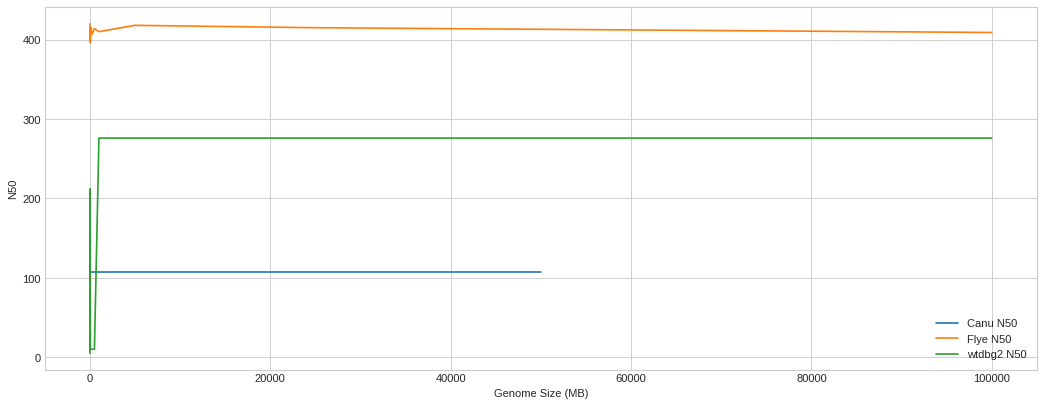

In [94]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

canu = pd.read_csv("/home/minion/Desktop/canu_N50.tsv", sep = "\t")
flye = pd.read_csv("/home/minion/Desktop/flye_N50.tsv", sep = "\t")
wtdbg2 = pd.read_csv("/home/minion/Desktop/wtdbg2_N50.tsv", sep = "\t")

fig=plt.figure(figsize=(16, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(canu.genome_size_mb, canu.scaf_N50, label='Canu N50')
plt.plot(flye.genome_size_mb, flye.scaf_N50, label='Flye N50')
plt.plot(wtdbg2.genome_size_mb, wtdbg2.ctg_N50, label='wtdbg2 N50')
#plt.plot(canu.genome_size_mb, canu.scaf_L50, color='#00FFFF', label='Canu L50')
#plt.plot(flye.genome_size_mb, flye.scaf_L50, color='#00FF00', label='Flye L50')
#plt.plot(wtdbg2.genome_size_mb, wtdbg2.ctg_L50, color='#FF00FF', label='wtdbg2 L50')

plt.xlabel('Genome Size (MB)')
plt.ylabel('N50')

plt.legend()

plt.savefig('/home/minion/Desktop/N50_graph.png')
plt.show()

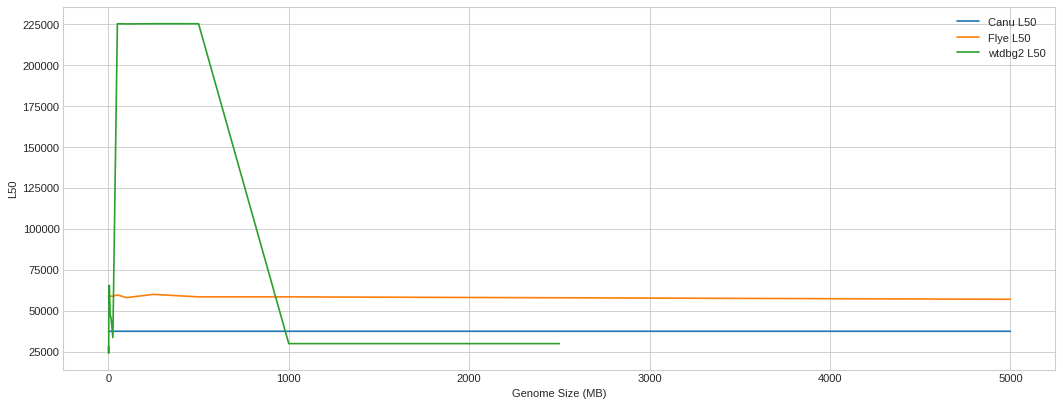

In [157]:
x = canu.iloc[:17]
y = flye.iloc[:17]
z = wtdbg2.iloc[:18]

fig=plt.figure(figsize=(16, 6), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(x.genome_size_mb, x.ctg_L50, label = "Canu L50")
plt.plot(y.genome_size_mb, y.ctg_L50, label = "Flye L50")
plt.plot(z.genome_size_mb, z.ctg_L50, label = "wtdbg2 L50")
plt.xlabel('Genome Size (MB)')
plt.ylabel('L50')

plt.legend()

plt.savefig('/home/minion/Desktop/L50_graph.png')

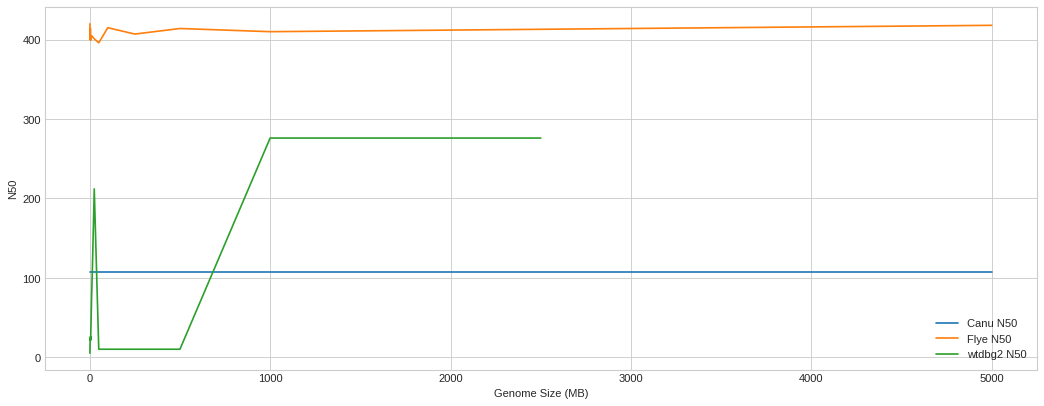

In [154]:
x = canu.iloc[:17]
y = flye.iloc[:17]
z = wtdbg2.iloc[:18]

fig=plt.figure(figsize=(16, 6), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(x.genome_size_mb, x.ctg_N50, label = "Canu N50")
plt.plot(y.genome_size_mb, y.ctg_N50, label = "Flye N50")
plt.plot(z.genome_size_mb, z.ctg_N50, label = "wtdbg2 N50")
plt.xlabel('Genome Size (MB)')
plt.ylabel('N50')

plt.legend()

plt.savefig('/home/minion/Desktop/N50_graph.png')

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

canu = pd.read_csv("/home/minion/Desktop/canu_N50.tsv", sep = "\t")
canu

,n_scaffolds,n_contigs,scaf_bp,contig_bp,gap_pct,scaf_N50,scaf_L50,ctg_N50,ctg_L50,scaf_N90,scaf_L90,ctg_N90,ctg_L90,scaf_max,ctg_max,scaf_n_gt50K,scaf_pct_gt50K,gc_avg,gc_std,filename
0,657,657,14176347,14176347,0.0,107,37357,107,37357,417,9221,417,9221,292020,292020,54,34.130,0.32499,0.05168,/gpfs/ts0/projects/Research_Project-172179/met...
1,657,657,14176332,14176332,0.0,107,37357,107,37357,417,9221,417,9221,292020,292020,54,34.131,0.32499,0.05167,/gpfs/ts0/projects/Research_Project-172179/met...
2,657,657,14176330,14176330,0.0,107,37357,107,37357,417,9221,417,9221,292017,292017,54,34.131,0.32499,0.05168,/gpfs/ts0/projects/Research_Project-172179/met...
3,657,657,14176352,14176352,0.0,107,37358,107,37358,417,9221,417,9221,292019,292019,54,34.131,0.32499,0.05167,/gpfs/ts0/projects/Research_Project-172179/met...
4,657,657,14176353,14176353,0.0,107,37359,107,37359,417,9221,417,9221,292050,292050,54,34.131,0.32499,0.05167,/gpfs/ts0/projects/Research_Project-172179/met...
5,657,657,14176382,14176382,0.0,107,37358,107,37358,417,9221,417,9221,292022,292022,54,34.131,0.32499,0.05168,/gpfs/ts0/projects/Research_Project-172179/met...
6,657,657,14176322,14176322,0.0,107,37358,107,37358,417,9221,417,9221,292023,292023,54,34.131,0.32499,0.05167,/gpfs/ts0/projects/Research_Project-172179/met...
7,657,657,14176370,14176370,0.0,107,37357,107,37357,417,9221,417,9221,292018,292018,54,34.130,0.32499,0.05168,/gpfs/ts0/projects/Research_Project-172179/met...
8,657,657,14176320,14176320,0.0,107,37357,107,37357,417,9221,417,9221,292022,292022,54,34.131,0.32499,0.05168,/gpfs/ts0/projects/Research_Project-172179/met...
9,657,657,14176339,14176339,0.0,107,37357,107,37357,417,9221,417,9221,292018,292018,54,34.130,0.32499,0.05168,/gpfs/ts0/projects/Research_Project-172179/met...


In [ ]:
from Bio import SeqIO
import glob
import os

file_list = glob.glob('BATS_80m_3.q7.pass.porechop.fq')
for f in file_list:
       base_name = os.path.basename(f)
       new_filename = '%s.filtered.10k.fa' % base_name
       records_to_keep = [x for x in SeqIO.parse(f, 'fastq') if len(x.seq)>=10000]
       SeqIO.write(records_to_keep, new_filename, 'fastq')

In [ ]:
#start from assembled contigs (if short reads)
bowtie2-build bb_contigs_short_spades.fasta bb_contigs_short_spades;
bowtie2 -x bb_contigs_short_spades \
-1 2654_3__AE1712_C6_N1_7_80m.fwd.fq.gz \
-2 2654_3__AE1712_C6_N1_7_80m.rev.fq.gz \
--threads 8 \
--no-unal \
-S bb_contigs_short_spades.sam;
samtools view -F 4 -bS bb_contigs_short_spades.sam > bb_contigs_short_spades.raw.bam;
samtools sort bb_contigs_short_spades.raw.bam -o bb_contigs_short_spades.sorted.bam;
samtools index bb_contigs_short_spades.sorted.bam

#if long reads
minimap2 -x map-ont -t <threads> <target> <reads.fq.gz> | gzip -c > mapping.paf.gz 

racon -m 8 -x -6 -g -8 -w 500 \
../BATS_80m_3.q7.pass.porechop.fq.gz \
racon.paf.gz \
racon.contigs.fasta \
-t 8 > racon-2.contigs.fasta

#each time you run racon you need to remap the new contigs created against the raw reads
minimap2 -x map-ont -t 8 \ #-x asm5 for short read mapping
racon-2.contigs.fasta \
../BATS_80m_3.q7.pass.porechop.fq.gz | gzip -c > racon-2.paf.gz

#medaka recomends running racon 4 times for polishing first
#run on local machine
medaka_consensus \
-i BATS_80m_3.q7.pass.porechop.fq.gz \
-d racon-4.contigs.fasta \
-o medaka_racon_wtdbg2_shortreads \
-t 8 -b 50 2>&1 | tee medaka.log #-b --batchsize 50 reduced memory

In [ ]:
checkM
conda install -c <?> checkm
conda install -c bioconda pysam # fix checkM install libhts.so.1

#checkm if not sure lineage/many different lineages
checkm lineage_wf ./bins ./output -x fasta

#if want to set checkm lineage 
checkm taxonomy_wf family Pelagibacteraceae bin/ checkm_output --force_overwrite -x fasta -t 1 

#or save to file
checkm taxonomy_wf family Pelagibacteraceae bin/ checkm_output --force_overwrite -x fasta -t 1 --tab_table --file completeness.txt